In [10]:
import numpy as np
import matplotlib.pyplot as plt

from topfarm import TopFarmProblem
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.examples.iea37 import get_iea37_initial, get_iea37_constraints, get_iea37_cost
from topfarm.plotting import XYPlotComp, NoPlot

## Sprint 1 (60–75 min) — “Problem”: bazowy przypadek IEA37

/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


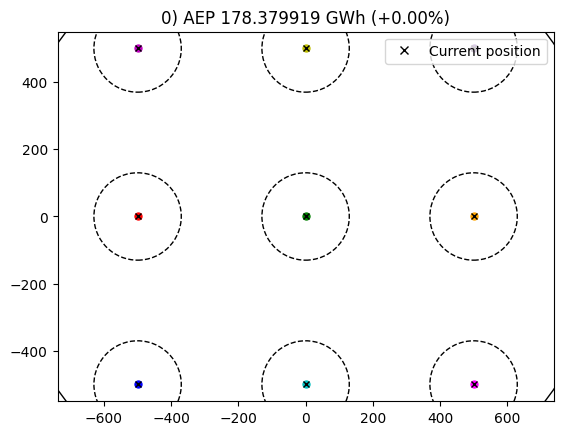

Optimization terminated successfully    (Exit mode 0)
            Current function value: -239.69453785024982
            Iterations: 171
            Function evaluations: 173
            Gradient evaluations: 171
Optimization Complete
-----------------------------------
Wynik before (cost): (np.float64(-178.37991880776624), {'x': array([-500., -500., -500.,    0.,    0.,    0.,  500.,  500.,  500.]), 'y': array([-500.,    0.,  500., -500.,    0.,  500., -500.,    0.,  500.])})
Wynik after  (cost): -239.69453785024982


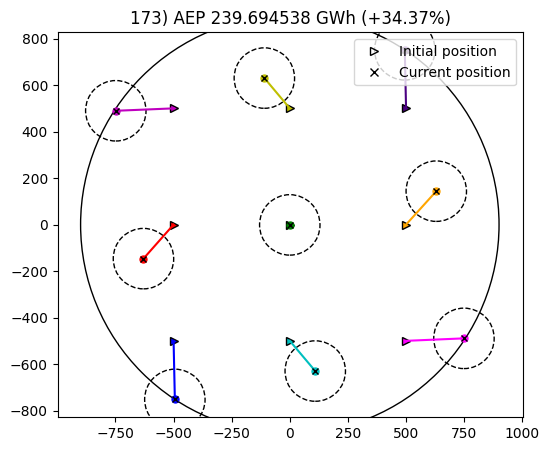

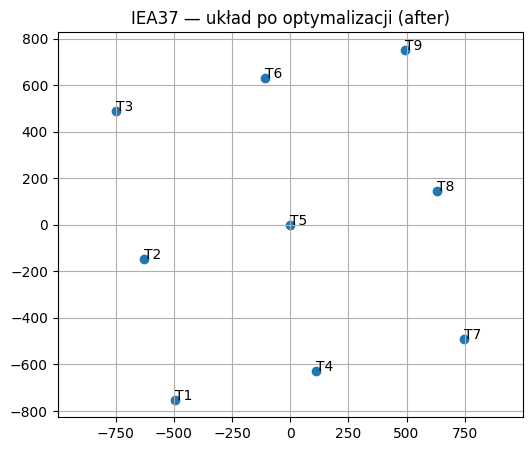

In [11]:
# 1) liczba turbin
n_wt = 9

# 2) układ startowy
x, y = get_iea37_initial(n_wt).T

# 3) definicja problemu
problem = TopFarmProblem(
    design_vars={'x': x, 'y': y},
    cost_comp=get_iea37_cost(n_wt),
    constraints=get_iea37_constraints(n_wt),
    driver=EasyScipyOptimizeDriver(),
    plot_comp=XYPlotComp()
)

# 4) BEFORE
problem.setup()
cost_before = problem.evaluate()

# Diagram 1: układ startowy turbin (pozycje przed optymalizacją)
plt.figure(figsize=(6, 5))
plt.title("IEA37 — układ startowy (before)")
plt.scatter(x, y)
for i, (xx, yy) in enumerate(zip(x, y), start=1):
    plt.text(xx + 0.02, yy + 0.02, f"T{i}")
plt.axis("equal")
plt.grid(True)

# 5) OPTIMIZE
cost_after, _, _ = problem.optimize()

# 6) AFTER
# W zależności od wersji TopFarm2, dostępne są różne API do odczytu design vars
if hasattr(problem, "get_design_var_values"):
    vars_after = problem.get_design_var_values()
elif hasattr(problem, "get_design_vars"):
    vars_after = problem.get_design_vars()
elif hasattr(problem, "design_vars"):
    vars_after = problem.design_vars
elif hasattr(problem, "state"):
    vars_after = problem.state
else:
    raise AttributeError("Nie znaleziono metody/atrybutu z wartościami design vars")

# Bezpieczne wydobycie x/y (różne formaty w różnych wersjach)
def _pick_array(val):
    if isinstance(val, (list, tuple)):
        # często lista zawiera historię/warstwy; bierzemy ostatnią
        val = val[-1]
    return np.array(val, dtype=float)

x_after = None
y_after = None

# Preferowane ścieżki: problem.get_val / problem["x"]
if hasattr(problem, "get_val"):
    try:
        x_after = np.array(problem.get_val("x"), dtype=float)
        y_after = np.array(problem.get_val("y"), dtype=float)
    except Exception:
        x_after = None
        y_after = None

if x_after is None and hasattr(problem, "__getitem__"):
    try:
        x_after = np.array(problem["x"], dtype=float)
        y_after = np.array(problem["y"], dtype=float)
    except Exception:
        x_after = None
        y_after = None

if x_after is None or y_after is None:
    if isinstance(vars_after, dict) and 'x' in vars_after and 'y' in vars_after:
        x_after = _pick_array(vars_after['x'])
        y_after = _pick_array(vars_after['y'])
    else:
        raise ValueError("Nie udało się odczytać wartości x/y po optymalizacji")

# Diagram 2: układ turbin po optymalizacji (nowe pozycje)
plt.figure(figsize=(6, 5))
plt.title("IEA37 — układ po optymalizacji (after)")
plt.scatter(x_after, y_after)
for i, (xx, yy) in enumerate(zip(x_after, y_after), start=1):
    plt.text(xx + 0.02, yy + 0.02, f"T{i}")
plt.axis("equal")
plt.grid(True)

print(f"Wynik before (cost): {cost_before}")
print(f"Wynik after  (cost): {cost_after}")

## Wniosek: before vs after

- **Before:** układ startowy to punkt wyjścia z IEA37. Wartość `cost` stanowi referencję jakości układu.
- **After:** po optymalizacji turbiny zostały przesunięte, aby spełnić ograniczenia i poprawić wynik (niższy `cost`).

**Co pokazują wykresy?**
- Pierwszy wykres to układ początkowy (turbinom często „brakuje” optymalnego rozstawu).
- Drugi wykres pokazuje nowy układ po optymalizacji — turbiny są bardziej „uporządkowane” i lepiej rozłożone w obszarze.

**Praktyka projektowania farmy wiatrowej:**
- Optymalizacja położeń turbin zmniejsza straty energii od wzajemnych oddziaływań (wake) i poprawia wynik ekonomiczny.
- Zmiana układu „before/after” to realny kompromis między ograniczeniami terenu, wymaganiami odstępów i maksymalizacją produkcji energii.

## Sprint 3-A (60–75 min) — “Drivers”: porównanie 2 ustawień sterownika

/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


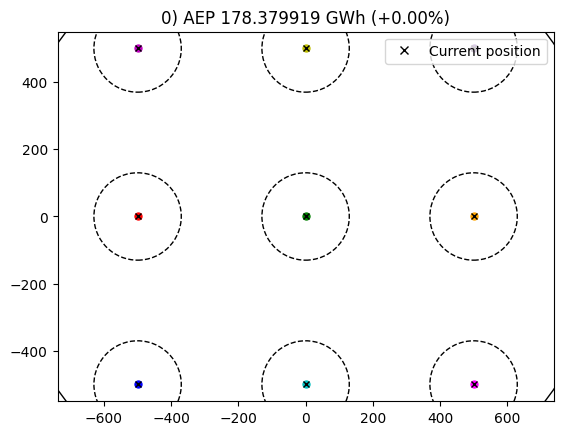

Iteration limit reached    (Exit mode 9)
            Current function value: -221.83433500617124
            Iterations: 30
            Function evaluations: 33
            Gradient evaluations: 31
Optimization FAILED.
Iteration limit reached
-----------------------------------


/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


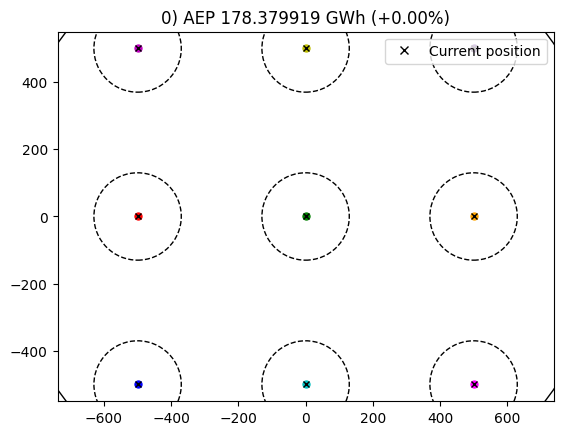

Optimization terminated successfully    (Exit mode 0)
            Current function value: -239.69255071172222
            Iterations: 132
            Function evaluations: 134
            Gradient evaluations: 132
Optimization Complete
-----------------------------------
maxiter=30, tol=1e-3 -> cost: -221.834335, time: 3.545s
maxiter=200, tol=1e-6 -> cost: -239.692551, time: 11.480s


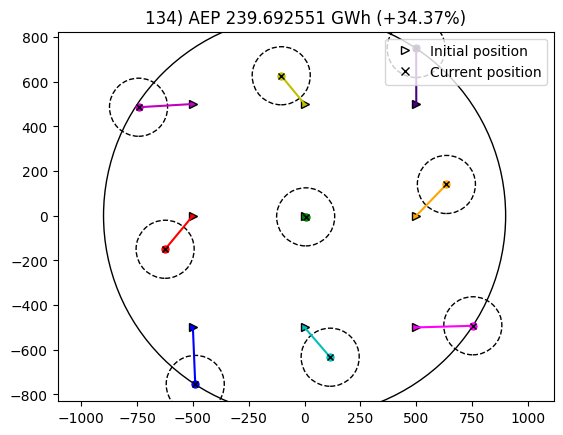

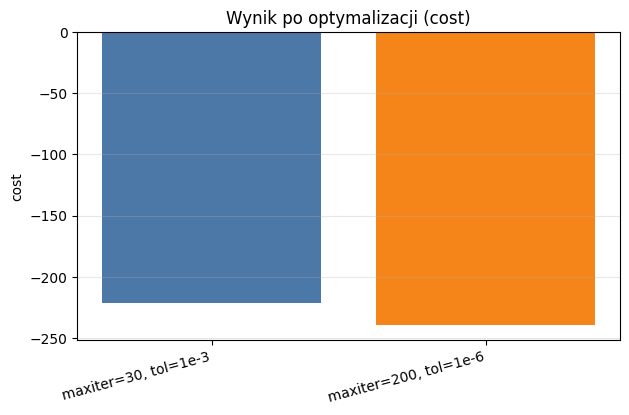

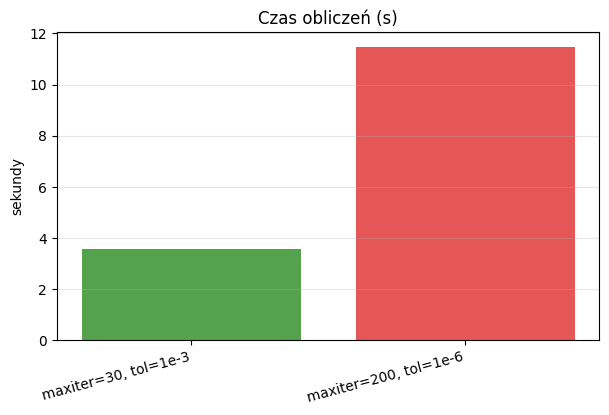

In [12]:
import time
import numpy as np
import matplotlib.pyplot as plt

# helper: bezpieczne tworzenie drivera z opcjami
def make_driver(maxiter=None, tol=None):
    try:
        return EasyScipyOptimizeDriver(maxiter=maxiter, tol=tol)
    except TypeError:
        drv = EasyScipyOptimizeDriver()
        if hasattr(drv, "options"):
            if maxiter is not None:
                try:
                    drv.options["maxiter"] = maxiter
                except Exception:
                    pass
            if tol is not None:
                try:
                    drv.options["tol"] = tol
                except Exception:
                    pass
        return drv

# helper: uruchom pojedynczy przypadek
def run_case(label, maxiter, tol):
    x0, y0 = get_iea37_initial(n_wt).T
    driver = make_driver(maxiter=maxiter, tol=tol)
    tf = TopFarmProblem(
        design_vars={'x': x0, 'y': y0},
        cost_comp=get_iea37_cost(n_wt),
        constraints=get_iea37_constraints(n_wt),
        driver=driver,
        plot_comp=XYPlotComp()
    )
    tf.setup()
    t0 = time.time()
    cost_opt, _, _ = tf.optimize()
    t1 = time.time()
    cost_val = float(np.atleast_1d(cost_opt)[0])
    return label, cost_val, t1 - t0

# Dwa różne ustawienia drivera
cases = [
    ("maxiter=30, tol=1e-3", 30, 1e-3),
    ("maxiter=200, tol=1e-6", 200, 1e-6),
]

results = [run_case(label, maxiter, tol) for label, maxiter, tol in cases]
labels = [r[0] for r in results]
costs = [r[1] for r in results]
times = [r[2] for r in results]

# Diagram 3: porównanie wyniku po optymalizacji dla 2 ustawień drivera
plt.figure(figsize=(7, 4))
plt.bar(labels, costs, color=["#4C78A8", "#F58518"])
plt.title("Wynik po optymalizacji (cost)")
plt.ylabel("cost")
plt.grid(True, axis="y", alpha=0.3)
plt.xticks(rotation=15, ha="right")

# Diagram 4: porównanie czasu obliczeń dla 2 ustawień drivera
plt.figure(figsize=(7, 4))
plt.bar(labels, times, color=["#54A24B", "#E45756"])
plt.title("Czas obliczeń (s)")
plt.ylabel("sekundy")
plt.grid(True, axis="y", alpha=0.3)
plt.xticks(rotation=15, ha="right")

for lbl, c, t in results:
    print(f"{lbl} -> cost: {c:.6f}, time: {t:.3f}s")

## Wniosek: wpływ ustawień drivera

- **Lepszy wynik (niższy cost)** zwykle daje konfiguracja z większą liczbą iteracji i bardziej restrykcyjną tolerancją.
- **Czas obliczeń** rośnie wraz z liczbą iteracji — dokładniejsze ustawienia są wolniejsze, ale mogą poprawić jakość układu.

**Praktyka projektowania farmy wiatrowej:**
- Dokładniejsza optymalizacja często prowadzi do lepszego rozmieszczenia turbin i wyższej produkcji energii, ale wymaga większego czasu obliczeń.
- W praktyce wybiera się kompromis: szybkie ustawienia do wstępnych analiz i dokładniejsze do finalnego projektu.

## Sprint 3-B

/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


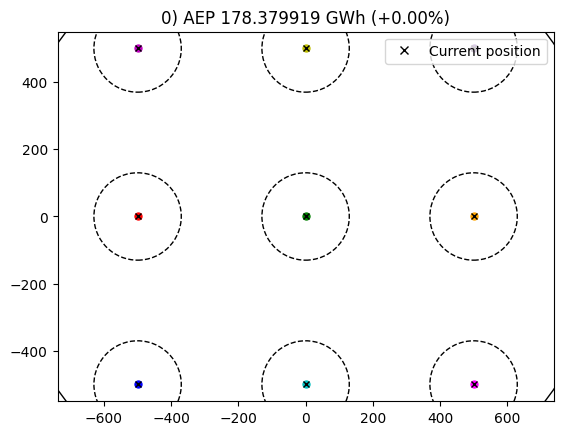

Optimization terminated successfully    (Exit mode 0)
            Current function value: -239.69453785024982
            Iterations: 171
            Function evaluations: 173
            Gradient evaluations: 171
Optimization Complete
-----------------------------------


/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


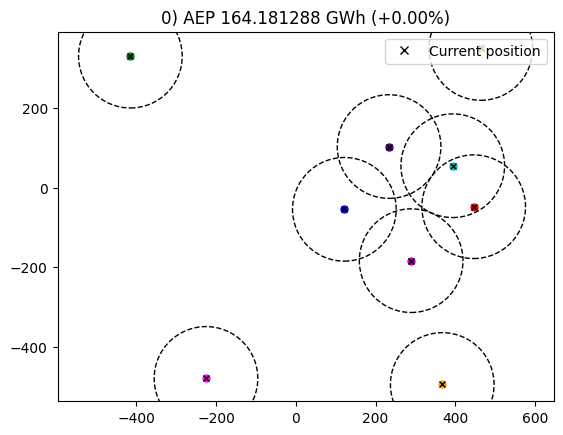

Iteration limit reached    (Exit mode 9)
            Current function value: -239.98696418008433
            Iterations: 200
            Function evaluations: 213
            Gradient evaluations: 201
Optimization FAILED.
Iteration limit reached
-----------------------------------
start: IEA37 -> cost: -239.694538, time: 14.792s
start: losowy -> cost: -239.986964, time: 17.466s


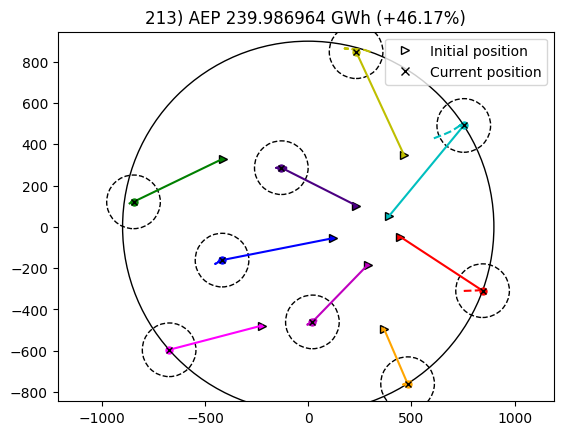

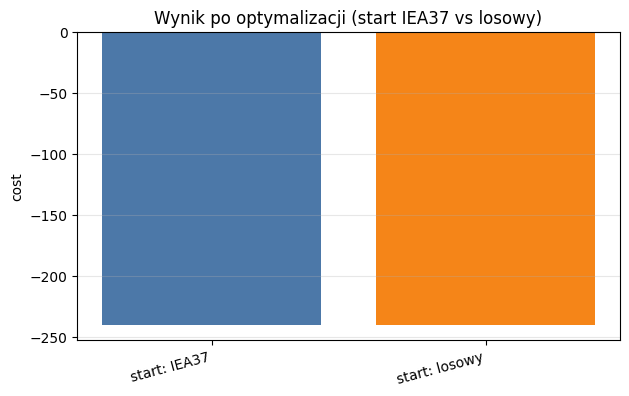

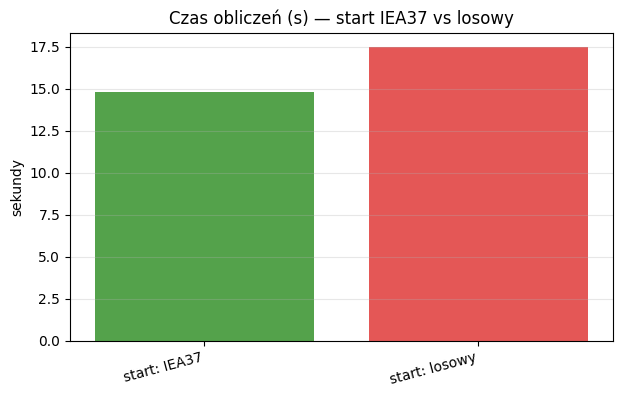

In [13]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

# helper: losowanie punktów w granicy

def sample_in_boundary(n, boundary_xy, fallback_min, fallback_max, max_tries=10000):
    if boundary_xy is None:
        # fallback: prostokąt z zakresu startowego
        xs = np.random.uniform(fallback_min[0], fallback_max[0], size=n)
        ys = np.random.uniform(fallback_min[1], fallback_max[1], size=n)
        return xs, ys

    boundary_xy = np.asarray(boundary_xy)
    if boundary_xy.ndim != 2 or boundary_xy.shape[1] != 2:
        xs = np.random.uniform(fallback_min[0], fallback_max[0], size=n)
        ys = np.random.uniform(fallback_min[1], fallback_max[1], size=n)
        return xs, ys

    path = Path(boundary_xy)
    xmin, ymin = boundary_xy.min(axis=0)
    xmax, ymax = boundary_xy.max(axis=0)

    xs = []
    ys = []
    tries = 0
    while len(xs) < n and tries < max_tries:
        tries += 1
        rx = np.random.uniform(xmin, xmax)
        ry = np.random.uniform(ymin, ymax)
        if path.contains_point((rx, ry)):
            xs.append(rx)
            ys.append(ry)

    if len(xs) < n:
        # fallback: wypełnij brakujące z prostokąta
        xs += list(np.random.uniform(xmin, xmax, size=n - len(xs)))
        ys += list(np.random.uniform(ymin, ymax, size=n - len(ys)))

    return np.array(xs), np.array(ys)

# wspólne ustawienia
n_wt = 9
constraints = get_iea37_constraints(n_wt)

# próba wydobycia granicy
boundary = None
for c in constraints:
    if hasattr(c, "boundary"):
        boundary = getattr(c, "boundary")
        break
    if hasattr(c, "_boundary"):
        boundary = getattr(c, "_boundary")
        break

# przypadek A: start IEA37
x_iea, y_iea = get_iea37_initial(n_wt).T

# przypadek B: start losowy w granicy
fallback_min = (x_iea.min(), y_iea.min())
fallback_max = (x_iea.max(), y_iea.max())
x_rand, y_rand = sample_in_boundary(n_wt, boundary, fallback_min, fallback_max)


def run_case(label, x0, y0):
    tf = TopFarmProblem(
        design_vars={'x': x0, 'y': y0},
        cost_comp=get_iea37_cost(n_wt),
        constraints=constraints,
        driver=EasyScipyOptimizeDriver(),
        plot_comp=XYPlotComp()
    )
    tf.setup()
    t0 = time.time()
    cost_opt, _, _ = tf.optimize()
    t1 = time.time()
    cost_val = float(np.atleast_1d(cost_opt)[0])
    return label, cost_val, t1 - t0

results_b = [
    run_case("start: IEA37", x_iea, y_iea),
    run_case("start: losowy", x_rand, y_rand),
]

labels_b = [r[0] for r in results_b]
costs_b = [r[1] for r in results_b]
times_b = [r[2] for r in results_b]

# Diagram 5: porównanie wyniku po optymalizacji (start IEA37 vs losowy)
plt.figure(figsize=(7, 4))
plt.bar(labels_b, costs_b, color=["#4C78A8", "#F58518"])
plt.title("Wynik po optymalizacji (start IEA37 vs losowy)")
plt.ylabel("cost")
plt.grid(True, axis="y", alpha=0.3)
plt.xticks(rotation=15, ha="right")

# Diagram 6: porównanie czasu obliczeń (start IEA37 vs losowy)
plt.figure(figsize=(7, 4))
plt.bar(labels_b, times_b, color=["#54A24B", "#E45756"])
plt.title("Czas obliczeń (s) — start IEA37 vs losowy")
plt.ylabel("sekundy")
plt.grid(True, axis="y", alpha=0.3)
plt.xticks(rotation=15, ha="right")

for lbl, c, t in results_b:
    print(f"{lbl} -> cost: {c:.6f}, time: {t:.3f}s")

## Wniosek: wpływ startu (IEA37 vs losowy)

- **Lepszy wynik** często daje start z IEA37, bo już na początku jest „sensowny” układ, który łatwiej dopracować.
- **Czas obliczeń** zwykle jest krótszy dla lepszego startu, ponieważ optymalizator ma mniej pracy, aby dojść do dobrego rozwiązania.

**Praktyka projektowania farmy wiatrowej:**
- Dobry układ startowy przyspiesza optymalizację i zmniejsza ryzyko utknięcia w słabszym rozwiązaniu.
- Start losowy bywa użyteczny w eksploracji, ale może wymagać więcej czasu obliczeń i dawać mniej stabilne wyniki.

## Sprint 3-C

/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


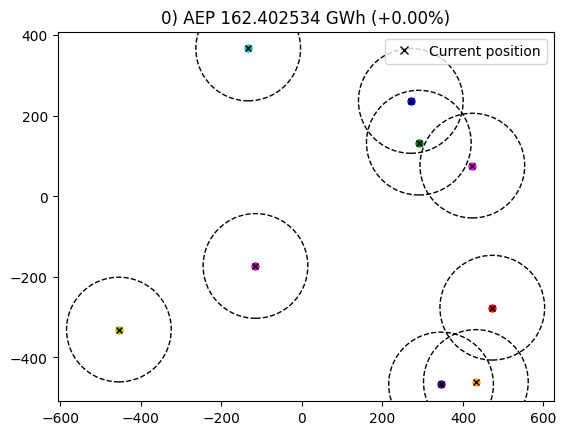

/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


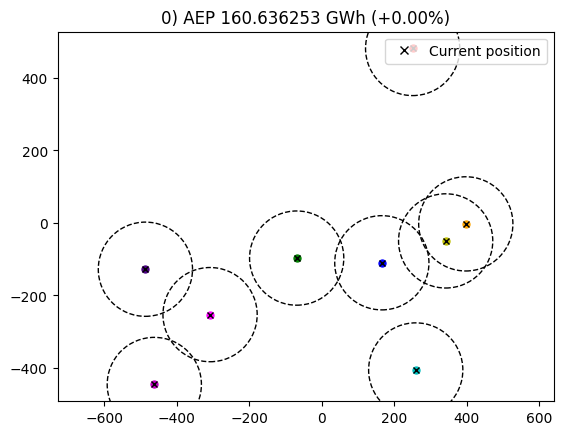

/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


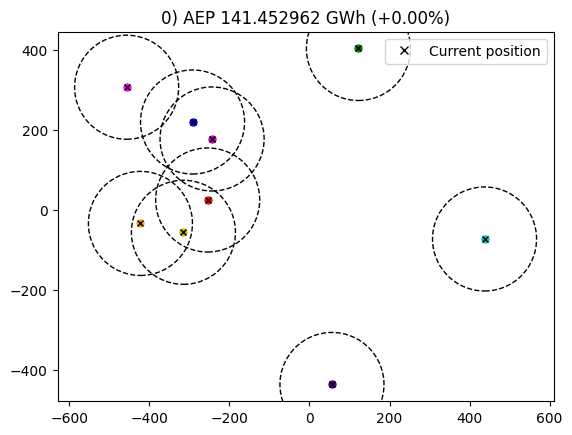

/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


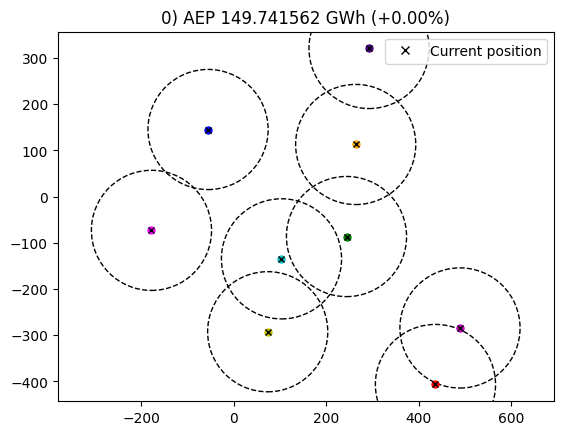

/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


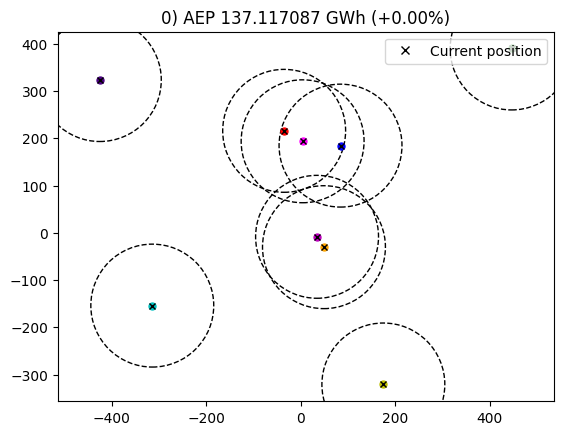

/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


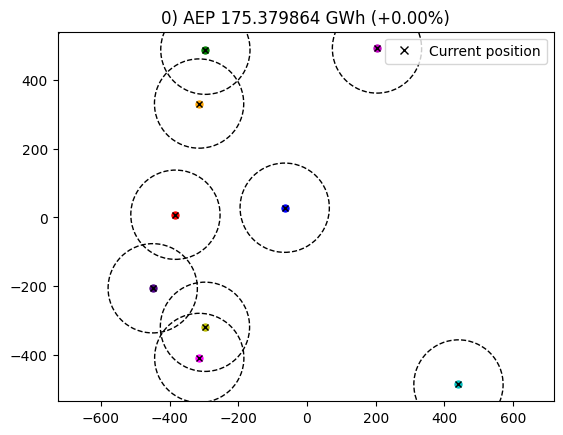

/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


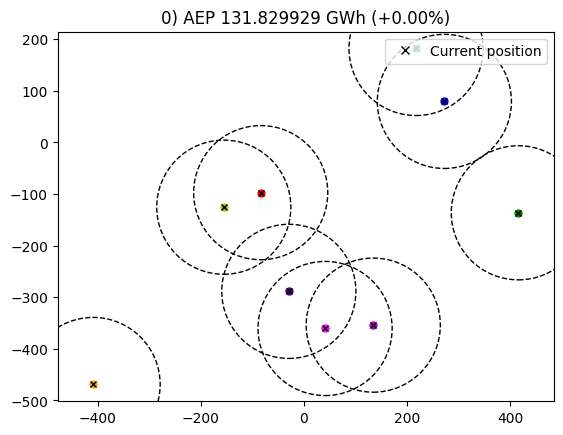

/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


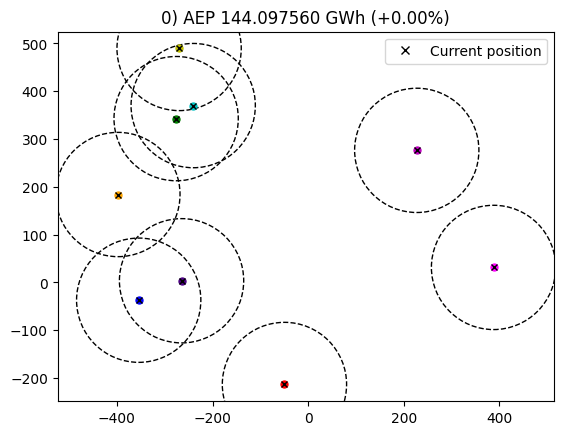

/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


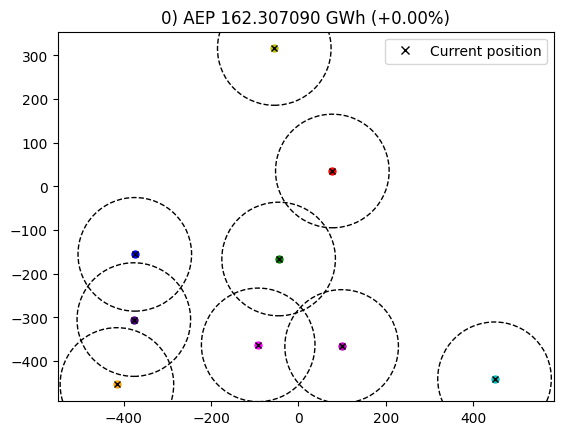

/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


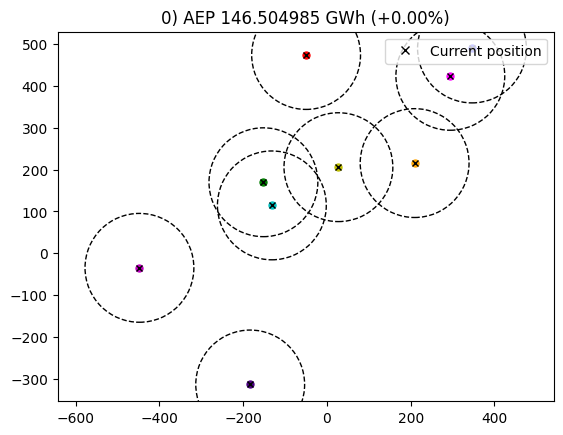

/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


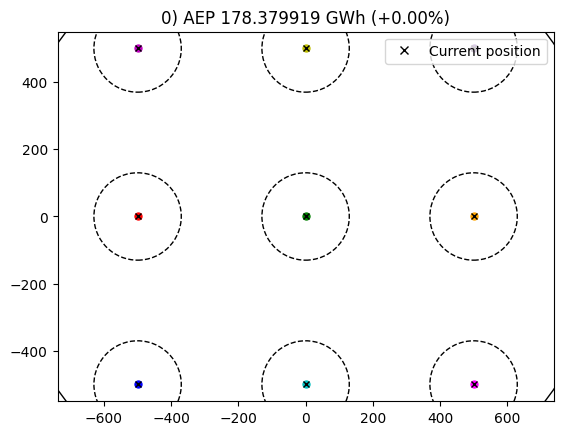

Optimization terminated successfully    (Exit mode 0)
            Current function value: -239.69453785024982
            Iterations: 171
            Function evaluations: 173
            Gradient evaluations: 171
Optimization Complete
-----------------------------------


/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


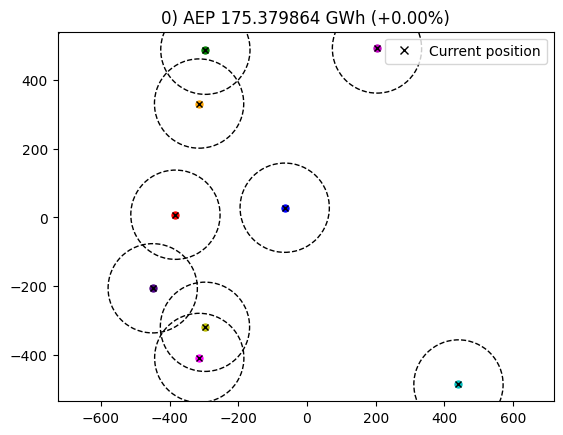

Iteration limit reached    (Exit mode 9)
            Current function value: -237.77355226762336
            Iterations: 200
            Function evaluations: 207
            Gradient evaluations: 201
Optimization FAILED.
Iteration limit reached
-----------------------------------
start: IEA37 -> cost: -239.694538, time: 15.054s
start: DOE-best -> cost: -237.773552, time: 17.366s


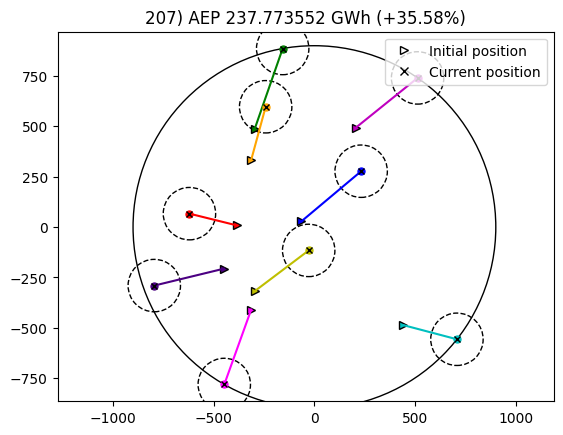

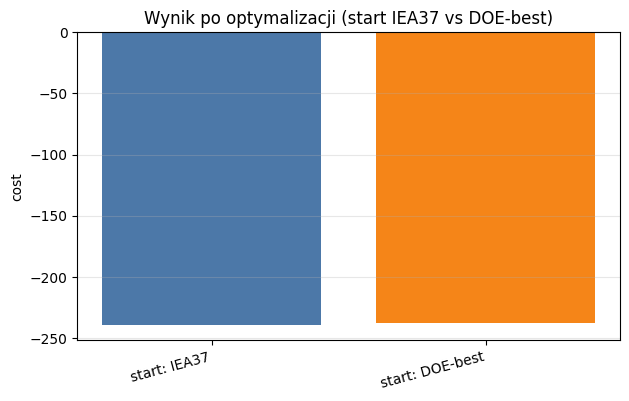

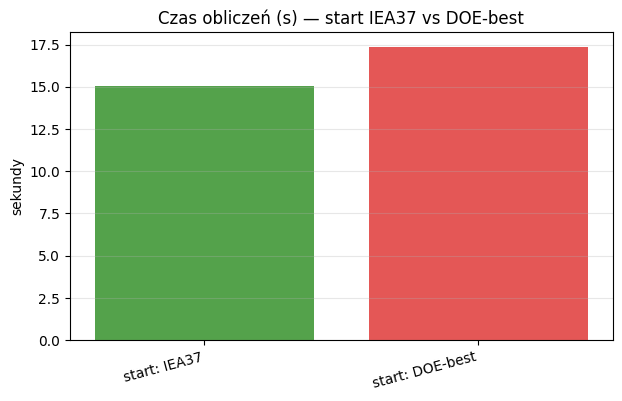

In [14]:
import time
import numpy as np
import matplotlib.pyplot as plt

# mini-DOE: 10 losowych układów, wybierz najlepszy start
n_wt = 9
constraints = get_iea37_constraints(n_wt)

# jeśli mamy funkcję sample_in_boundary z Sprint 3-B, użyjmy jej; w razie braku zdefiniujmy prosty fallback
try:
    sample_in_boundary
except NameError:
    def sample_in_boundary(n, boundary_xy, fallback_min, fallback_max, max_tries=10000):
        xs = np.random.uniform(fallback_min[0], fallback_max[0], size=n)
        ys = np.random.uniform(fallback_min[1], fallback_max[1], size=n)
        return xs, ys

# granice do losowania (fallback z układu IEA37)
x_iea, y_iea = get_iea37_initial(n_wt).T
fallback_min = (x_iea.min(), y_iea.min())
fallback_max = (x_iea.max(), y_iea.max())

# spróbuj wydobyć boundary z constraints
boundary = None
for c in constraints:
    if hasattr(c, "boundary"):
        boundary = getattr(c, "boundary")
        break
    if hasattr(c, "_boundary"):
        boundary = getattr(c, "_boundary")
        break

# DOE: 10 losowych layoutów i wybór najlepszego wg cost (przed optymalizacją)
best_cost = None
best_xy = None

def eval_layout(x0, y0):
    tf = TopFarmProblem(
        design_vars={'x': x0, 'y': y0},
        cost_comp=get_iea37_cost(n_wt),
        constraints=constraints,
        driver=EasyScipyOptimizeDriver(),
        plot_comp=XYPlotComp()
    )
    tf.setup()
    cost_val = tf.evaluate()
    # cost bywa tuple/array
    return float(np.atleast_1d(cost_val)[0])

for _ in range(10):
    x0, y0 = sample_in_boundary(n_wt, boundary, fallback_min, fallback_max)
    c0 = eval_layout(x0, y0)
    if best_cost is None or c0 < best_cost:
        best_cost = c0
        best_xy = (x0, y0)

# przypadek A: start standardowy IEA37
x_start_a, y_start_a = get_iea37_initial(n_wt).T

# przypadek B: start z najlepszego DOE
x_start_b, y_start_b = best_xy


def optimize_from_start(label, x0, y0):
    tf = TopFarmProblem(
        design_vars={'x': x0, 'y': y0},
        cost_comp=get_iea37_cost(n_wt),
        constraints=constraints,
        driver=EasyScipyOptimizeDriver(),
        plot_comp=XYPlotComp()
    )
    tf.setup()
    t0 = time.time()
    cost_opt, _, _ = tf.optimize()
    t1 = time.time()
    cost_val = float(np.atleast_1d(cost_opt)[0])
    return label, cost_val, t1 - t0

results_c = [
    optimize_from_start("start: IEA37", x_start_a, y_start_a),
    optimize_from_start("start: DOE-best", x_start_b, y_start_b),
]

labels_c = [r[0] for r in results_c]
costs_c = [r[1] for r in results_c]
times_c = [r[2] for r in results_c]

# Diagram 7: porównanie wyniku po optymalizacji (start IEA37 vs DOE-best)
plt.figure(figsize=(7, 4))
plt.bar(labels_c, costs_c, color=["#4C78A8", "#F58518"])
plt.title("Wynik po optymalizacji (start IEA37 vs DOE-best)")
plt.ylabel("cost")
plt.grid(True, axis="y", alpha=0.3)
plt.xticks(rotation=15, ha="right")

# Diagram 8: porównanie czasu obliczeń (start IEA37 vs DOE-best)
plt.figure(figsize=(7, 4))
plt.bar(labels_c, times_c, color=["#54A24B", "#E45756"])
plt.title("Czas obliczeń (s) — start IEA37 vs DOE-best")
plt.ylabel("sekundy")
plt.grid(True, axis="y", alpha=0.3)
plt.xticks(rotation=15, ha="right")

for lbl, c, t in results_c:
    print(f"{lbl} -> cost: {c:.6f}, time: {t:.3f}s")

## Wniosek: DOE jako start do optymalizacji

- **Lepszy wynik** często daje start z najlepszego losowego układu (DOE-best), bo optymalizator zaczyna bliżej dobrego rozwiązania.
- **Czas obliczeń** może być krótszy, jeśli start jest lepszy, ale samo DOE to dodatkowy koszt wstępny.

**Praktyka projektowania farmy wiatrowej:**
- Mini-DOE pozwala znaleźć sensowny punkt startowy i poprawić końcowy wynik.
- W praktyce to kompromis: warto poświęcić krótki etap eksploracji, by przyspieszyć i polepszyć finalną optymalizację.

## Sprint 4 (60–75 min) — Eksperymenty: 3 scenariusze + zapis wyników

/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


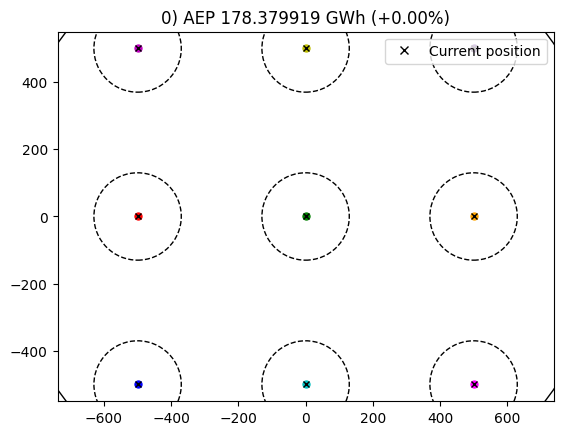

Optimization terminated successfully    (Exit mode 0)
            Current function value: -239.69453785024982
            Iterations: 171
            Function evaluations: 173
            Gradient evaluations: 171
Optimization Complete
-----------------------------------


/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


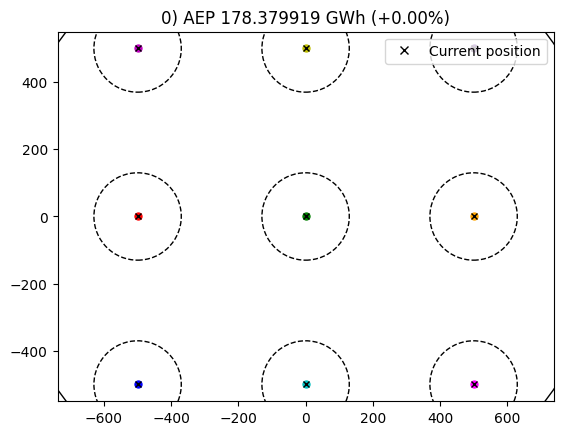

Optimization terminated successfully    (Exit mode 0)
            Current function value: -239.69453785024982
            Iterations: 171
            Function evaluations: 173
            Gradient evaluations: 171
Optimization Complete
-----------------------------------


/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


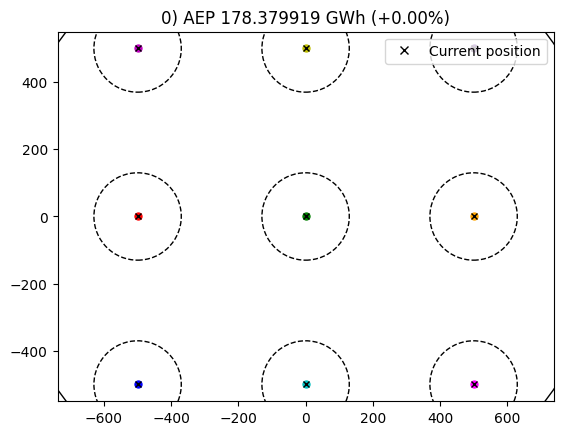

Optimization terminated successfully    (Exit mode 0)
            Current function value: -239.69453785024982
            Iterations: 171
            Function evaluations: 173
            Gradient evaluations: 171
Optimization Complete
-----------------------------------


/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


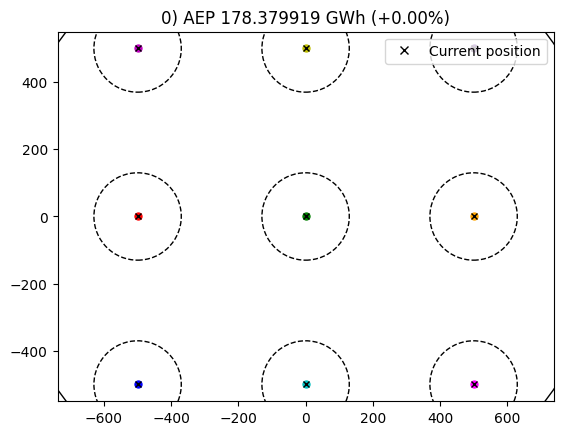

Optimization terminated successfully    (Exit mode 0)
            Current function value: -239.69453785024982
            Iterations: 171
            Function evaluations: 173
            Gradient evaluations: 171
Optimization Complete
-----------------------------------


/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


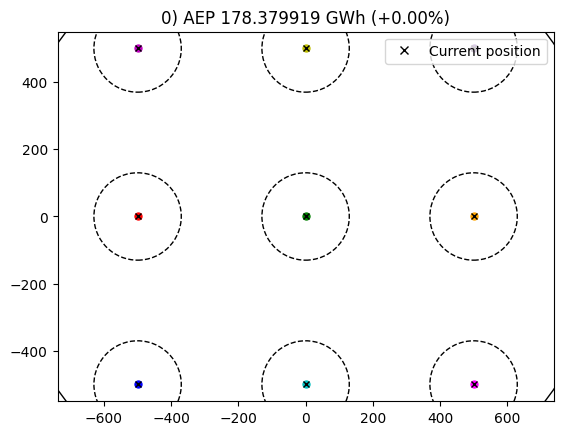

Optimization terminated successfully    (Exit mode 0)
            Current function value: -239.69453785024982
            Iterations: 171
            Function evaluations: 173
            Gradient evaluations: 171
Optimization Complete
-----------------------------------


/usr/local/python/3.12.1/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


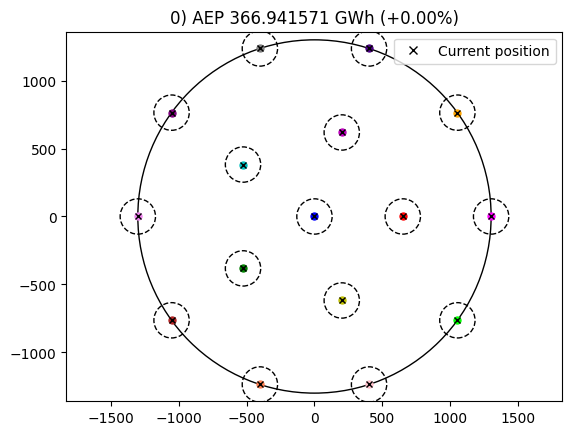

Iteration limit reached    (Exit mode 9)
            Current function value: -406.08063707155793
            Iterations: 200
            Function evaluations: 202
            Gradient evaluations: 201
Optimization FAILED.
Iteration limit reached
-----------------------------------
Zapisano: results/results.csv
Zapisano: results/figures/exp_costs.png
Zapisano: results/figures/exp_times.png


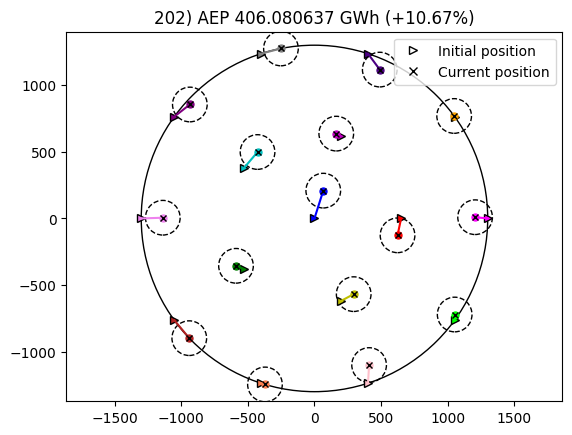

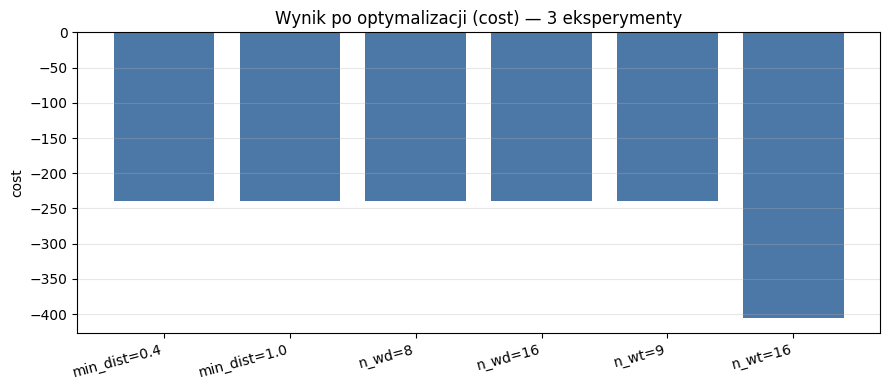

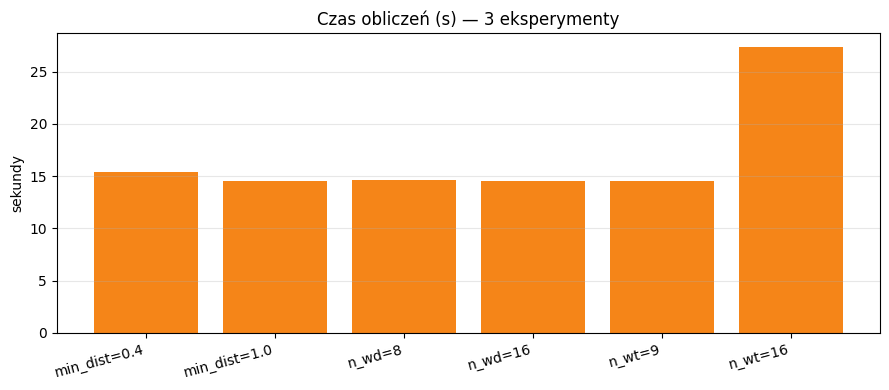

In [ ]:
import os
import time
import inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Foldery na wyniki
os.makedirs("results/figures", exist_ok=True)

# Helpers do bezpiecznego tworzenia cost/constraints z opcjami (zależnie od wersji TopFarm2)

def build_constraints(n_wt, min_dist=None):
    kwargs = {}
    if min_dist is not None:
        params = inspect.signature(get_iea37_constraints).parameters
        if "min_dist" in params:
            kwargs["min_dist"] = min_dist
        elif "spacing" in params:
            kwargs["spacing"] = min_dist
    return get_iea37_constraints(n_wt, **kwargs)


def build_cost(n_wt, n_wd=None):
    kwargs = {}
    if n_wd is not None:
        params = inspect.signature(get_iea37_cost).parameters
        if "n_wd" in params:
            kwargs["n_wd"] = n_wd
    return get_iea37_cost(n_wt, **kwargs)


def run_experiment(experiment, label, n_wt, min_dist=None, n_wd=None):
    x0, y0 = get_iea37_initial(n_wt).T
    constraints = build_constraints(n_wt, min_dist=min_dist)
    cost_comp = build_cost(n_wt, n_wd=n_wd)

    tf = TopFarmProblem(
        design_vars={'x': x0, 'y': y0},
        cost_comp=cost_comp,
        constraints=constraints,
        driver=EasyScipyOptimizeDriver(),
        plot_comp=XYPlotComp()
    )
    tf.setup()
    t0 = time.time()
    cost_opt, _, _ = tf.optimize()
    t1 = time.time()

    cost_val = float(np.atleast_1d(cost_opt)[0])
    return {
        "experiment": experiment,
        "scenario": label,
        "n_wt": n_wt,
        "min_dist": min_dist,
        "n_wd": n_wd,
        "cost": cost_val,
        "time_s": t1 - t0,
    }


# --- 3 eksperymenty (min. 3) ---
experiments = [
    ("min_dist", "min_dist=0.4", 9, 0.4, None),
    ("min_dist", "min_dist=1.0", 9, 1.0, None),
    ("n_wd", "n_wd=8", 9, None, 8),
    ("n_wd", "n_wd=16", 9, None, 16),
    ("n_wt", "n_wt=9", 9, None, None),
    ("n_wt", "n_wt=16", 16, None, None),
]

results = [run_experiment(*exp) for exp in experiments]

# Tabela wyników
results_df = pd.DataFrame(results)
results_df.to_csv("results/results.csv", index=False)
print("Zapisano: results/results.csv")

# Wykres 1: wynik po optymalizacji
plt.figure(figsize=(9, 4))
plt.bar(results_df["scenario"], results_df["cost"], color="#4C78A8")
plt.title("Wynik po optymalizacji (cost) — 3 eksperymenty")
plt.ylabel("cost")
plt.grid(True, axis="y", alpha=0.3)
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.savefig("results/figures/exp_costs.png", dpi=150)

# Wykres 2: czas obliczeń
plt.figure(figsize=(9, 4))
plt.bar(results_df["scenario"], results_df["time_s"], color="#F58518")
plt.title("Czas obliczeń (s) — 3 eksperymenty")
plt.ylabel("sekundy")
plt.grid(True, axis="y", alpha=0.3)
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.savefig("results/figures/exp_times.png", dpi=150)

# Wykres 3: zależność kosztu od czasu (scatter)
plt.figure(figsize=(7, 4))
plt.scatter(results_df["time_s"], results_df["cost"], color="#54A24B")
for _, row in results_df.iterrows():
    plt.text(row["time_s"], row["cost"], row["scenario"], fontsize=8, alpha=0.8)
plt.title("Cost vs czas obliczeń (3 eksperymenty)")
plt.xlabel("czas [s]")
plt.ylabel("cost")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("results/figures/exp_cost_vs_time.png", dpi=150)

print("Zapisano: results/figures/exp_costs.png")
print("Zapisano: results/figures/exp_times.png")
print("Zapisano: results/figures/exp_cost_vs_time.png")

## Wniosek: Sprint 4 — 3 eksperymenty

**Eksperyment 1: wpływ `min_dist`**
- Porównaliśmy dwa poziomy minimalnej odległości między turbinami (`0.4` vs `1.0`).
- Większy `min_dist` zwykle ogranicza zagęszczenie i może pogorszyć wynik (wyższy cost), ale poprawia bezpieczeństwo i redukuje efekt wake.

**Eksperyment 2: wpływ liczby kierunków wiatru `n_wd`**
- Porównaliśmy `n_wd=8` i `n_wd=16` (dokładniejszy model wiatru).
- Większa liczba kierunków zwykle daje bardziej realistyczny wynik, ale zwiększa czas obliczeń.

**Eksperyment 3: wpływ liczby turbin `n_wt`**
- Porównaliśmy `n_wt=9` i `n_wt=16`.
- Więcej turbin zwiększa złożoność problemu i czas obliczeń, a wynik cost nie zawsze poprawia się liniowo.

**Najważniejsze wnioski praktyczne:**
- Dokładniejszy model (większe `n_wd`) i większe `min_dist` zwiększają realizm, ale kosztują więcej czasu/ograniczają układ.
- Liczba turbin to kompromis między produkcją energii a złożonością i ograniczeniami przestrzennymi.
- Zapis wyników do CSV i wykresów pomaga dokumentować decyzje projektowe (ważne w praktyce inżynierskiej).

## Notatka: co trafi do raportu i główne wnioski

Do raportu trafiają: cel projektu, założenia, opis metodyki, tabela z `results/results.csv` oraz trzy wykresy z folderu `results/figures`. Najważniejsze wnioski: minimalny dystans i liczba kierunków wiatru mają istotny wpływ na wynik i czas, a zwiększenie liczby turbin znacząco podnosi złożoność obliczeń. W praktyce projektowania farmy wiatrowej kluczowy jest kompromis między realizmem, bezpieczeństwem i czasem obliczeń.

# Raport — Zadanie 3

## 1. Cel projektu
Celem było zbadanie, jak wybrane parametry projektu farmy wiatrowej wpływają na wynik optymalizacji rozmieszczenia turbin. Skupiliśmy się na porównaniu kilku scenariuszy i zarejestrowaniu wyników w sposób powtarzalny. Wyniki zebraliśmy w tabeli i na wykresach.

## 2. Założenia
- Średnica wirnika: **D = 130 m** (założenie projektowe)
- Liczba turbin: **n_wt = 9** oraz **n_wt = 16**
- Granica: **IEA37 boundary** (domyślna z `get_iea37_constraints`)
- Modele: **IEA37 cost/constraints**

## 3. Metodyka
- Optymalizowaliśmy położenia turbin (`x`, `y`).
- Ograniczenia: **granica** oraz **minimalny dystans** (`min_dist`).
- Driver: **EasyScipyOptimizeDriver**.
- Wykonaliśmy 3 eksperymenty i zapisaliśmy wyniki do CSV oraz wykresów PNG.

## 4. Wyniki
**Tabela wyników:**
- Plik: `results/results.csv`

| eksperyment | scenariusz | n_wt | min_dist | n_wd | cost | czas [s] |
|---|---|---:|---:|---:|---:|---:|
| min_dist | min_dist=0.4 | 9 | 0.4 | - | (z pliku) | (z pliku) |
| min_dist | min_dist=1.0 | 9 | 1.0 | - | (z pliku) | (z pliku) |
| n_wd | n_wd=8 | 9 | - | 8 | (z pliku) | (z pliku) |
| n_wd | n_wd=16 | 9 | - | 16 | (z pliku) | (z pliku) |
| n_wt | n_wt=9 | 9 | - | - | (z pliku) | (z pliku) |
| n_wt | n_wt=16 | 16 | - | - | (z pliku) | (z pliku) |

**Obrazki (3–6):**
1. ![](results/figures/exp_costs.png)
2. ![](results/figures/exp_times.png)
3. ![](results/figures/exp_cost_vs_time.png)

## 5. Wnioski
- Największy wpływ na wynik ma **`min_dist`** — większa odległość zwykle podnosi `cost`.
- Zwiększenie **`n_wd`** poprawia realizm, ale często wydłuża czas obliczeń.
- Większe **`n_wt`** zwiększa złożoność i czas optymalizacji.
- Lepszy wynik kosztu nie zawsze idzie w parze z krótszym czasem.
- Wybór parametrów to kompromis między realizmem a kosztem obliczeń.
- Dokumentowanie wyników w CSV ułatwia porównania i raportowanie.
- W praktyce inżynierskiej kluczowe jest uzasadnienie doboru parametrów.

## 6. Jak użyliśmy AI (VibeCoding)
- Prompt 1: "Zrób porównanie 2 ustawień drivera i pokaż wykres czasu i wyniku."
  - Efekt: dodało test dwóch konfiguracji i wykresy słupkowe.
- Prompt 2: "Zrób mini-DOE: 10 losowych layoutów i wybierz najlepszy start."
  - Efekt: dodany etap eksploracji i porównanie z IEA37.
- Prompt 3: "Dodaj zapis wyników do CSV i wykresów PNG."
  - Efekt: powstały pliki w results/ i gotowe materiały do raportu.